# Ping Pong King of the Hill Game Statistics Summary
*Author: Gaston Wolfart*

In [1]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import timedelta

## 1. Processing details

### 1.1 Loading data for one game

#### Preprocessing tests

In [2]:
# json format

json_string = '{"players":["Gaston","Mathieu","Marc"],"transitions":[{"Gaston":4},{"Mathieu":4},{"Marc":38},{"Gaston":12}]}'
data = json.loads(json_string)
data

{'players': ['Gaston', 'Mathieu', 'Marc'],
 'transitions': [{'Gaston': 4}, {'Mathieu': 4}, {'Marc': 38}, {'Gaston': 12}]}

In [3]:
# save to file as raw
with open('test.json', 'w') as outfile:
    outfile.write(json_string)

In [4]:
# save to file
with open('test.json', 'w') as outfile:
    json.dump(data, outfile, indent=4)

In [5]:
# read from file
read_data = {}
with open('test.json') as json_file:
    read_data = json.load(json_file)

print(read_data)

{'players': ['Gaston', 'Mathieu', 'Marc'], 'transitions': [{'Gaston': 4}, {'Mathieu': 4}, {'Marc': 38}, {'Gaston': 12}]}


In [6]:
players_json = read_data['players']
players_json

['Gaston', 'Mathieu', 'Marc']

In [7]:
transitions_json = read_data['transitions']
transitions_json

[{'Gaston': 4}, {'Mathieu': 4}, {'Marc': 38}, {'Gaston': 12}]

#### Dummy data

In [8]:
players = ['Marc', 'Mathieu', 'Gaston']
dummy_data = [
    ('Marc', 120),
    ('Mathieu', 20),
    ('Marc', 32),
    ('Gaston', 90),
    ('Mathieu', 70),
    ('Mathieu', 10),
    ('Marc', 25),
]
# dummy_data = [
#     ('Marc', 300),
# ]
dummy_df = pd.DataFrame(dummy_data, columns=['Name', 'Interval'])
dummy_df

,Name,Interval
0,Marc,120
1,Mathieu,20
2,Marc,32
3,Gaston,90
4,Mathieu,70
5,Mathieu,10
6,Marc,25


Game duration

In [9]:
total_duration_seconds = dummy_df['Interval'].sum()
print('Game lasted for %s (%d sec.)' % (timedelta(seconds=int(total_duration_seconds)), total_duration_seconds))

Game lasted for 0:06:07 (367 sec.)


Players names

In [10]:
print(players)

['Marc', 'Mathieu', 'Gaston']


Assign a color to each player for better plotting.

In [11]:
# determine consistent color palette for players
player_colors = {name:color for name, color in zip(players, sns.color_palette('Pastel1')[:len(players)])}
player_colors

{'Marc': (0.984313725490196, 0.7058823529411765, 0.6823529411764706),
 'Mathieu': (0.7019607843137254, 0.803921568627451, 0.8901960784313725),
 'Gaston': (0.8, 0.9215686274509803, 0.7725490196078432)}

### 1.2 First and last king

In [12]:
print('First king: %s ' % dummy_df.iloc[0]['Name'])
print('Last king: %s ' % dummy_df.iloc[-1]['Name'])

First king: Marc 
Last king: Marc 


### 1.3 Number of crowns claimed

first king: Marc


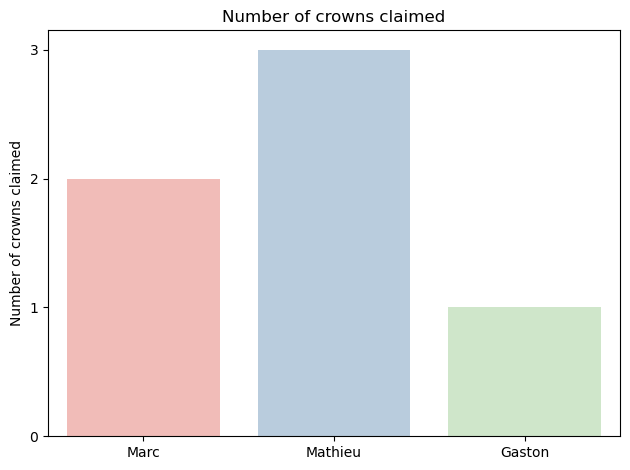

In [13]:
# number of times that a player claimed the crown

# need to remove first entry because crown was not claimed
first_king = dummy_df.iloc[0]['Name']
print('first king:', first_king)

crowns_claimed = dummy_df.groupby('Name').count().rename({'Interval': 'Claimed'}, axis=1).sort_values('Claimed', ascending=False)
crowns_claimed.loc[first_king]['Claimed'] -= 1

# include other players
if len(crowns_claimed) < len(players):
    for player in players:
        if player not in crowns_claimed.index:
            crowns_claimed =  pd.concat([crowns_claimed, pd.DataFrame({'Claimed': 0}, index=[player])])


# plotting
sns.barplot(x=crowns_claimed.index, y=crowns_claimed.Claimed, palette=player_colors)

plt.xlabel('')
plt.yticks(range(0, int(np.ceil(crowns_claimed['Claimed'].max())) + 1))
plt.ylabel('Number of crowns claimed')
plt.title('Number of crowns claimed')
plt.tight_layout()
plt.show()

### 1.4 Total time as king

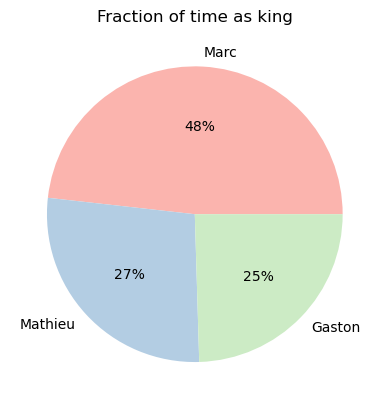

In [14]:
total_time_king = dummy_df.groupby('Name').sum().rename({'Interval': 'Duration'}, axis=1).sort_values('Duration', ascending=False)

# include other players
if len(total_time_king) < len(players):
    for player in players:
        if player not in total_time_king.index:
            total_time_king =  pd.concat([total_time_king, pd.DataFrame({'Duration': 0}, index=[player])])

# plotting
plt.pie(total_time_king['Duration'], labels=total_time_king.index, autopct='%.0f%%', colors=[player_colors[key] for key in player_colors])
plt.title('Fraction of time as king')
plt.show()

### 1.5 Mean reign duration

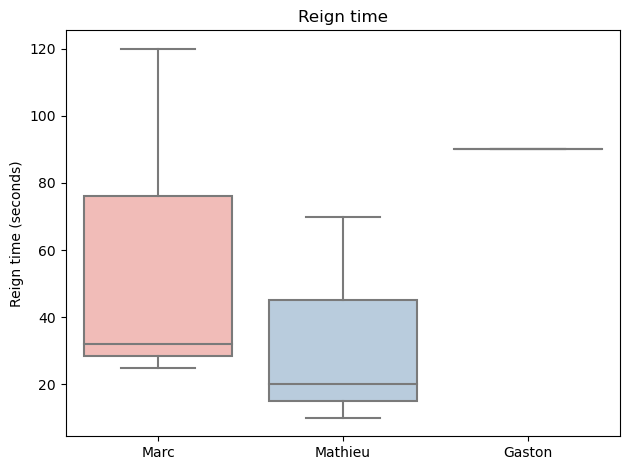

In [15]:
mean_reign_time = dummy_df

# include other players
if len(mean_reign_time['Name'].unique()) < len(players):
    for player in players:
        if player not in mean_reign_time['Name'].unique():
            mean_reign_time =  pd.concat([mean_reign_time, pd.DataFrame({'Name': [player], 'Interval':[0]})])

sns.boxplot(mean_reign_time, x='Name', y='Interval', palette=player_colors)

plt.xlabel('')
plt.ylabel('Reign time (seconds)')
plt.title('Reign time')
plt.tight_layout()
plt.show()


### 1.6 (experimental) Transition graph

Goal is to have something like this
```
Gaston        x-------------x
              |             |
Marc    ------x             |               x------>
                            |               |
Mathieu                     x---------------x
```

One possible way:
1. Encode each name by int value
2. Transform time interval to percentage of game time.
3. Create vector of length 100 with encoding values of player.

In [16]:
dummy_df['interval_perc'] = dummy_df['Interval'].apply(lambda x: int(np.ceil(x/total_duration_seconds * 100)))
dummy_df

,Name,Interval,interval_perc
0,Marc,120,33
1,Mathieu,20,6
2,Marc,32,9
3,Gaston,90,25
4,Mathieu,70,20
5,Mathieu,10,3
6,Marc,25,7


In [17]:
graph_vector = []

for _, transition in dummy_df.iterrows():
    graph_vector.extend(transition.Name for i in range(transition.interval_perc))
set(graph_vector)

{'Gaston', 'Marc', 'Mathieu'}

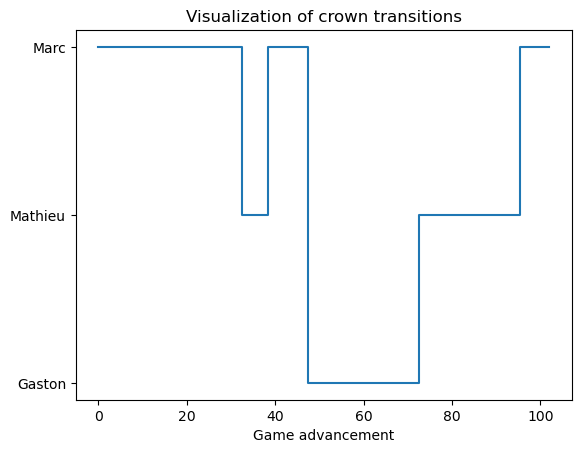

In [18]:
sns.lineplot(x=range(len(graph_vector)), y=graph_vector, drawstyle='steps-mid')
plt.xlabel('Game advancement')
plt.title('Visualization of crown transitions')
plt.show()

### Summary

Game duration: 0:06:07 
First king: Marc | Last king: Marc 


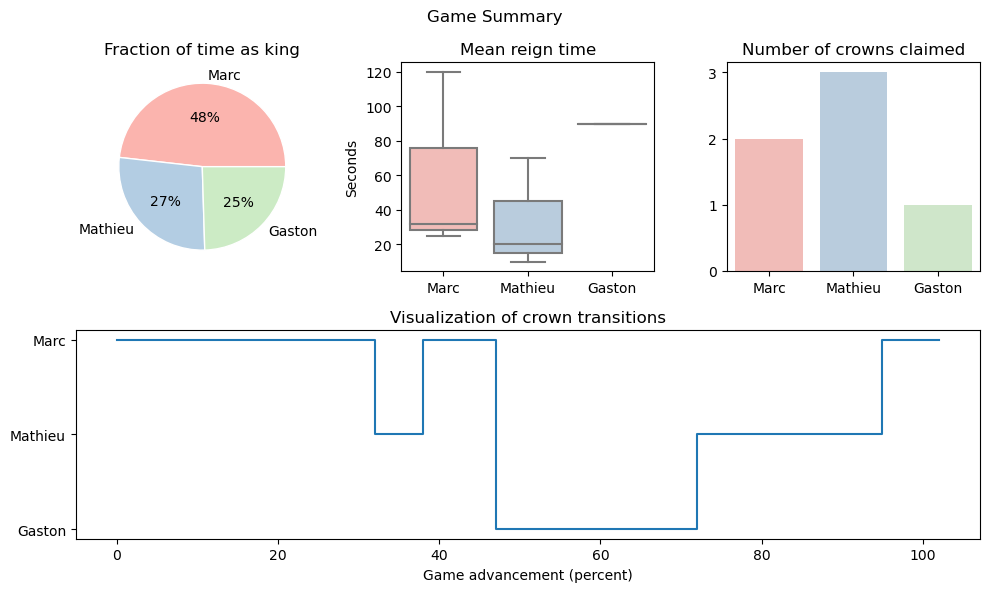

In [19]:
print('Game duration: %s ' % str(timedelta(seconds=int(total_duration_seconds))))
print('First king: %s | Last king: %s ' % (dummy_df.iloc[0]['Name'], dummy_df.iloc[-1]['Name']))

fig = plt.figure(tight_layout=True, figsize=(10, 6))
gs = gridspec.GridSpec(2, 3)

# Total Time as king
ax = fig.add_subplot(gs[0, 0])
pie_wedges = ax.pie(total_time_king['Duration'], labels=total_time_king.index, autopct='%.0f%%')

for pie_wedge in pie_wedges[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(player_colors[pie_wedge.get_label()])

ax.set_title('Fraction of time as king')

# Mean Reign time
ax = fig.add_subplot(gs[0, 1])
sns.boxplot(mean_reign_time, x='Name', y='Interval', palette=player_colors, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Seconds')
ax.set_title('Mean reign time')

# Crowns claimed
ax = fig.add_subplot(gs[0, 2])
sns.barplot(x=crowns_claimed.index, y=crowns_claimed.Claimed, palette=player_colors, ax=ax)
ax.set_yticks(range(0, int(np.ceil(crowns_claimed['Claimed'].max())) + 1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of crowns claimed')

# Transition graph
ax = fig.add_subplot(gs[1, :])
sns.lineplot(x=range(len(graph_vector)), y=graph_vector, drawstyle='steps', ax=ax)
ax.set_xlabel('Game advancement (percent)')
ax.set_title('Visualization of crown transitions')

fig.suptitle('Game Summary')

plt.show()